### Plot Interactive Chart

In [1]:
# !pip install yfinance
# !pip install matplotlib
# !pip install pandas
# %pip install plotly
# %pip install nbformat
# %pip install html2image
# %pip install ta

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.trend import MACD
from ta.momentum import StochasticOscillator
from html2image import Html2Image
from IPython.display import Image
import os

In [3]:
PLOT_WIDTH = 800
PLOT_HEIGHT = 600

In [4]:
def calculate_rsi_sma(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def smma(series, period):
    smma = series.copy()
    smma.iloc[:period] = series.iloc[:period].mean()  # seed with SMA
    for i in range(period, len(series)):
        smma.iloc[i] = ((smma.iloc[i - 1] * (period - 1)) + series.iloc[i]) / period
    return smma

def calculate_rsi_smma(data, period=14):
    delta = data.diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = smma(gain, period)
    avg_loss = smma(loss, period)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_rsi_ema(data, period=14):
    # Calculate price change
    delta = data.diff()

    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Apply Exponential Moving Average
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def prepare_df(ticker, days=0, start_date='2024-09-01', end_date='2025-08-31', average_method='sma'):
    '''
    average_method: 
        'sma' for Simple Moving Average
        'smma' for Smoothing Moving Average
        'ema' for Exponential Moving Average
    '''
    if days > 0:
        df = yf.download(ticker, period=f'{days}d', auto_adjust=True, progress=False)
    else:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
    
    # keep only the "Open", "Close" etc for plotly. also remove the unnecessary [] of df['Close'].values
    df.columns = df.columns.droplevel(1)    

    if average_method == 'sma':
        df['RSI'] = calculate_rsi_sma(df['Close'])
    elif average_method == 'smma':
        df['RSI'] = calculate_rsi_smma(df['Close'])
    elif average_method == 'ema':
        df['RSI'] = calculate_rsi_ema(df['Close'])
    else:
        df['RSI'] = calculate_rsi_sma(df['Close'])

    # add moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA5'] = df['Close'].rolling(window=5).mean()

    # MACD
    macd = MACD(close=df['Close'],
                      window_slow=26,
                      window_fast=12,
                      window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    # stochastic
    stoch = StochasticOscillator(high=df['High'],
                                       close=df['Close'],
                                       low=df['Low'],
                                       window=14,
                                       smooth_window=3)
    df['Stoch'] = stoch.stoch()
    df['Stoch_Signal'] = stoch.stoch_signal()

    return df

In [5]:
def plot_financial_chart(df, title='Financial Chart', height=PLOT_HEIGHT, width=PLOT_WIDTH):
    fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                        row_heights=[0.4, 0.1, 0.2, 0.2, 0.2])
    # 1. plot price
    fig.add_trace(
        go.Ohlc(
            x=df.index,
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name='Price'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['MA5'],
            opacity=0.7,
            line=dict(color='blue', width=2),
            name='MA 5'
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['MA20'],
            opacity=0.7,
            line=dict(color='orange', width=2),
            name='MA 20'
        ),
        row=1, col=1
    )
    fig.update_yaxes(
        title_text='Price', 
        automargin=False,
        title_standoff=100,        
        row=1, col=1
    )
    
    # 2. plot volume
    colors = ['green' if row['Open'] - row['Close'] >= 0 else 'red' for i, row in df.iterrows()]
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df['Volume'],
            marker_color=colors,
            name='Vol'
        ),
        row=2, col=1
    )
    fig.update_yaxes(
        title_text='Vol', 
        automargin=False,
        title_standoff=100,        
        row=2, col=1
    )
       
    # 3. plot RSI
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['RSI'],
            line=dict(color='red', width=2),
            name='RSI'
        ),
        row=3, col=1
    )
    fig.add_hline(y=70, line=dict(color='black', width=1), row=3, col=1)
    fig.add_hline(y=30, line=dict(color='black', width=1), row=3, col=1)
    fig.update_yaxes(
        title_text='RSI', 
        automargin=False,
        title_standoff=100,
        range=[0, 100],
        row=3, col=1
    )
   
    # 4. plot MACD
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['MACD'],
            line=dict(color='black', width=2),
            name='MACD'
        ),
        row=4, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['MACD_Signal'],
            line=dict(color='blue', width=1),
            name='MACD Signal'
        ),
        row=4, col=1
    )
    colors = ['green' if val >= 0 else 'red' for val in df['MACD_Diff']]
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df['MACD_Diff'],
            marker_color=colors,
            name='MACD Diff'
        ),
        row=4, col=1
    )
    fig.update_yaxes(
        title_text='MACD',    
        automargin=False,
        title_standoff=100,
        row=4, col=1
    )
       
    # 5. plot stochastics
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['Stoch'],
            line=dict(color='black', width=2),
            name='Stochastic'
        ),
        row=5, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df['Stoch_Signal'],
            line=dict(color='blue', width=1),
            name='Stoch Signal'
        ),
        row=5, col=1
    )
    fig.add_hline(y=80, line=dict(color='black', width=1), row=5, col=1)
    fig.add_hline(y=20, line=dict(color='black', width=1), row=5, col=1)
    fig.update_yaxes(
        title_text='Stoch',
        automargin=False,
        title_standoff=100,
        range=[0, 100],
        row=5, col=1
    )

    # update layout
    fig.update_layout(height=height, width=width, title=title)

    # hide weekends
    fig.update_xaxes(rangebreaks=[dict(bounds=['sat', 'mon'])])
    
    # range slider on last row
    fig.update_layout(
        xaxis_rangeslider_visible=False,
        xaxis2_rangeslider_visible=False,
        xaxis3_rangeslider_visible=False,
        xaxis4_rangeslider_visible=False,
        xaxis5_rangeslider_visible=True,
        xaxis5=dict(
            rangeslider=dict(
                thickness=0.05
            )
        ),
        xaxis=dict(
            showticklabels=True
        )
    )

    # add moving vertical line for reading values
    fig.update_layout(
        hovermode='x unified',
        hoverlabel=dict(
            bgcolor='rgba(255, 255, 255, 0.5)'
        )
    )

    # fig.layout.yaxis.title.update(title_standoff=20)
    # fig.layout.yaxis2.title.update(title_standoff=20)
    # fig.layout.yaxis3.title.update(title_standoff=20)
    # fig.layout.yaxis4.title.update(title_standoff=20)
    # fig.layout.yaxis5.title.update(title_standoff=20)


    # fig.update_layout(
    #     margin=go.layout.Margin(
    #         l=20,
    #         r=20,
    #         b=20
    #     )
    # )
    fig.show()
    return fig

In [6]:
df = prepare_df('QBTS', days=251)

In [7]:
fig = plot_financial_chart(df, title='QBTS')

#### Convert plotly chart into image
As Plotly chart does not show in github view, convert the above plot into image and show below.

86846 bytes written to file /Users/thyung/working/projects_github/stock_tools/qbts_1year.png


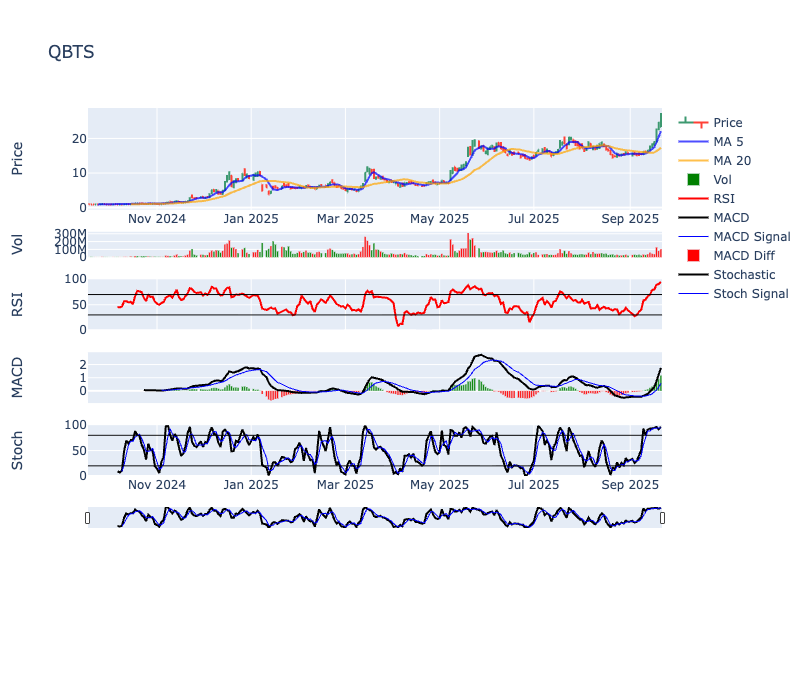

In [8]:
from IPython.display import HTML
fig.write_html('qbts_1year.html')
hti = Html2Image()
hti.screenshot(
    html_file='qbts_1year.html', 
    save_as='qbts_1year.png', 
    size=(PLOT_WIDTH, PLOT_HEIGHT + 100)     # add margin 100 or image is cropped
) 
os.remove('qbts_1year.html')
Image('qbts_1year.png')

#### Plot some charts

In [9]:
SYMBOLS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
dfs = {}
for symbol in SYMBOLS:
    dfs[symbol] = prepare_df(symbol, start_date='2022-09-01', end_date='2025-08-31', average_method='sma')

In [10]:
for symbol in SYMBOLS:
    plot_financial_chart(dfs[symbol], title=symbol)

In [11]:
pd.__version__

'2.3.2'

In [12]:
yf.__version__

'0.2.65'

In [13]:
import plotly
plotly.__version__

'6.3.0'

In [14]:
import nbformat
nbformat.__version__

'5.10.4'